## Testing with param

Providing `model` parameters and name, running simulation to produce energy deposition vs. time plot.

env: ASTERIA=/home/jakob/software/ASTERIA/ASTERIA


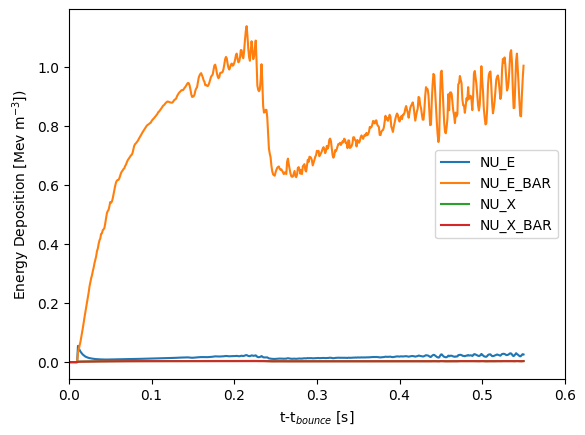

In [215]:
%env ASTERIA=/home/jakob/software/ASTERIA/ASTERIA
from asteria.simulation import Simulation
import astropy.units as u
import numpy as np

dt = 1*u.ms # highest frequency in Tamborra 2014 model

model = {'name': 'Tamborra_2014',
         'param':{
             'progenitor_mass': 27*u.Msun}
         }
sim = Simulation(model=model,
                 distance=10* u.kpc, 
                 Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                 tmin=0*u.s, tmax=0.55*u.s, dt=dt,
                 geomscope = 'Gen2')
sim.run()

import matplotlib.pyplot as plt
for flavor in sim.flavors:
    plt.plot(sim.time, sim.E_per_V[flavor], label=flavor.name)
plt.legend()
ax = plt.gca()
ax.set(xlabel=r't-t$_{bounce}$ [s]', ylabel='Energy Deposition [Mev m$^{-3}$])', xlim=(0, 0.6));

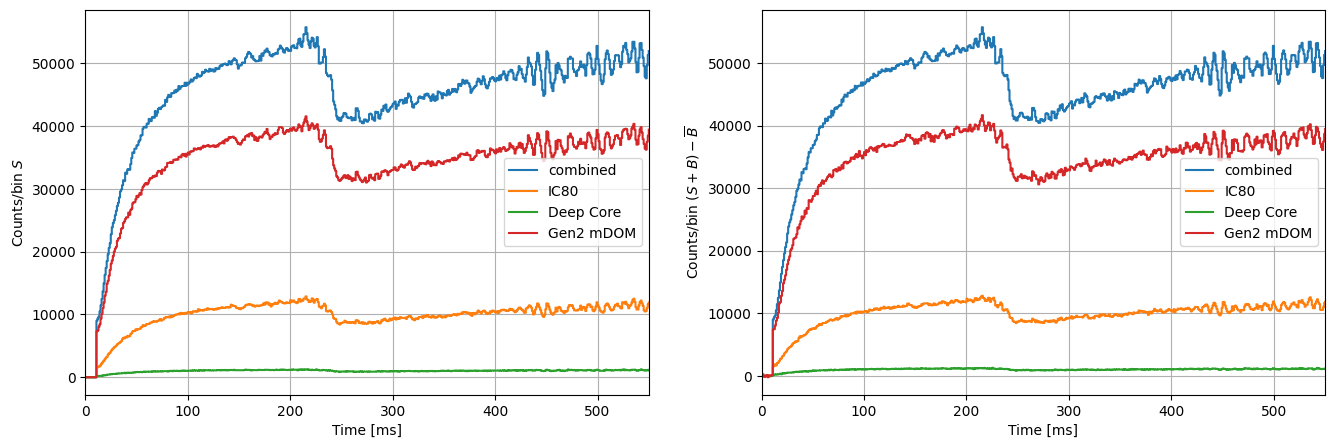

In [332]:
dt = 1*u.ms
sim.scale_result(distance=2*u.kpc)

t, i3_sig = sim.detector_hits(dt=dt, subdetector='i3')
t, dc_sig = sim.detector_hits(dt=dt, subdetector='dc')
t, md_sig = sim.detector_hits(dt=dt, subdetector='md')
t, comb_sig = sim.detector_hits(dt=dt)

t = t.to(u.ms)

i3_bkg = sim.detector.i3_bg(dt=dt, size=len(i3_sig))
dc_bkg = sim.detector.dc_bg(dt=dt, size=len(dc_sig))
md_bkg = sim.detector.md_bg(dt=dt, size=len(md_sig))
comb_bkg = i3_bkg + dc_bkg + md_bkg

i3 = i3_sig+i3_bkg
dc = dc_sig+dc_bkg
md = md_sig+md_bkg
comb = comb_sig+comb_bkg


fig, ax = plt.subplots(1,2, figsize=(16,5))
for i in range(2):
    if i == 0:
        ax[i].step(t, comb_sig, where='post', label='combined')
        ax[i].step(t, i3_sig, where='post', label='IC80')
        ax[i].step(t, dc_sig, where='post', label='Deep Core')
        ax[i].step(t, md_sig, where='post', label='Gen2 mDOM')
        ax[i].set_ylabel(r"Counts/bin $S$")

    elif i == 1:    
        ax[i].step(t, comb-comb_bkg, where='post', label='combined')
        ax[i].step(t, i3-i3_bkg.mean(), where='post', label='IC80')
        ax[i].step(t, dc-dc_bkg.mean(), where='post', label='Deep Core')
        ax[i].step(t, md-md_bkg.mean(), where='post', label='Gen2 mDOM')
        ax[i].set_ylabel(r"Counts/bin $(S+B)-\overline{B}$")

    ax[i].set_xlabel("Time [ms]")
    ax[i].set_xlim(0,550)
    ax[i].legend()
    ax[i].grid()

In [333]:
def moving_average(a, n=3, zero_padding = False, const_padding = False):
    if n%2 != 1:
        raise ValueError(f"n must be an uneven number but is {n}")
    if zero_padding:
        ind = np.arange(n-1)
        a = np.insert(a, ind, np.zeros(n-1))
        a = np.roll(a, -int((n-1)/2))
    if const_padding:
        ind1 = np.arange((n-1)/2).astype(int)
        ind2 = -np.arange(1,(n-1)/2+1).astype(int)
        a = np.insert(a, ind1, np.ones(int((n-1)/2))*a[0])
        a = np.insert(a, ind2, np.ones(int((n-1)/2))*a[-1])
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [334]:
def min_max_in_window(a, window):
    xmin, xmax = 0,0
    arg_min, arg_max = 0,0
    for i in np.arange(len(a)-window+1):
        interval = a[i:i+window]
        tmin = interval.min()
        tmax = interval.max()
        t_argmin = np.argmin(interval)+i
        t_argmax = np.argmax(interval)+i
        if tmax-tmin > xmax- xmin: 
            xmin, xmax = tmin, tmax
            arg_min, arg_max = t_argmin, t_argmax
    return xmax-xmin, arg_min, arg_max

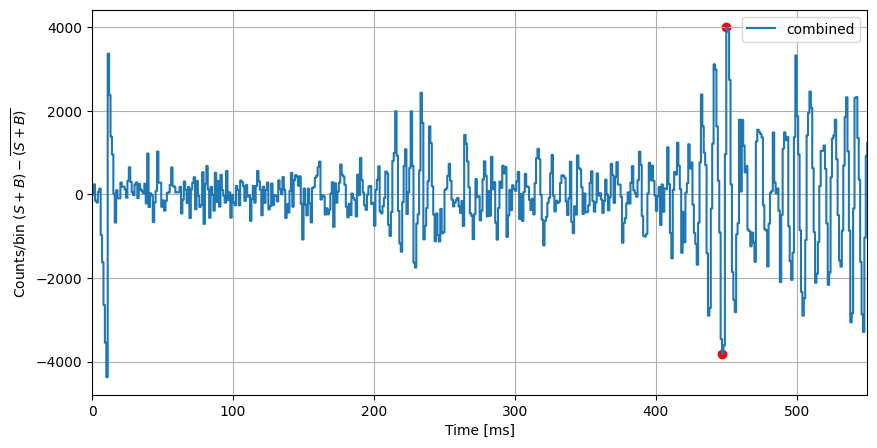

In [335]:
bw = 11

avg_i3 = moving_average(i3, n=bw, const_padding=True)
avg_dc = moving_average(dc, n=bw, const_padding=True)
avg_md = moving_average(md, n=bw, const_padding=True)
avg_comb = moving_average(comb, n=bw, const_padding=True)

dev_i3 = i3-avg_i3
dev_dc = dc-avg_dc
dev_md = md-avg_md
dev_comb = comb-avg_comb

sasi2_ampl, argmin, argmax = min_max_in_window(dev_comb[t>400*u.ms], window=10)

fig, ax = plt.subplots(1,1, figsize=(10,5))  
ax.step(t, dev_comb, where='post', label='combined')
ax.scatter(t[t>400*u.ms][argmin], dev_comb[t>400*u.ms][argmin], color = 'r', marker = 'o')
ax.scatter(t[t>400*u.ms][argmax], dev_comb[t>400*u.ms][argmax], color = 'r', marker = 'o')
#ax.step(t, dev_i3, where='post', label='IC80')
#ax.step(t, dev_dc, where='post', label='Deep Core')
#ax.step(t, dev_md, where='post', label='Gen2 mDOM')
ax.set_ylabel(r"Counts/bin $(S+B)-\overline{(S+B)}$")

ax.set_xlabel("Time [ms]")
ax.set_xlim(0,550)
ax.legend()
ax.grid()

In [337]:
np.std(comb_bkg)

214.0943505532442